In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
from bs4 import BeautifulSoup
import scrapy
import random
import time
from urllib.parse import urljoin
import re

In [3]:
arquivos_excel = ['sites_36.xlsx','sites_37.xlsx','sites_38.xlsx','sites_39.xlsx','sites_40.xlsx','sites_41.xlsx'
                  ,'sites_42.xlsx']
dados_brutos = [pd.read_excel(i) for i in arquivos_excel]
base = pd.concat(dados_brutos, ignore_index=True)

In [4]:
base.head(2)

,id,name,url,state,city,"sitemap_posts_url (sem data, index, webstories)",Google News Sitemap URL,rss_url (se presente),paywall,name_normalized
0,875,CLICKON,NaN,SP,São Paulo,NaN,NaN,NaN,NaN,clickon
1,876,CLICKSINDICO,NaN,RS,Porto Alegre,NaN,NaN,NaN,NaN,clicksindico


In [ ]:
# Alteração na base normalizada cortada para a pesquisa no navegador

#base['name_normalized'] = base['name_normalized'].str.replace(r'(estadao|com|\-|folha|g1|uol|\.)', '', regex=True)

In [5]:
# Alteração  na base Normalizada cortado alguns valores

base['name_normalized_cortado'] = base['name_normalized'].str.replace(r'\b(blog|no|na|do|da)\b', '', regex=True)
# Remover espaços extras resultantes da substituição
base['name_normalized_cortado'] = base['name_normalized_cortado'].str.strip().str.replace(r'\s+', ' ', regex=True)
# Supondo que 'base' seja o DataFrame e 'name_normalized_cortado' seja a coluna
base['name_normalized_cortado'] = base['name_normalized_cortado'].apply(lambda x: x.split() if isinstance(x, str) else x)
base['name_normalized_cortado']

0           [clickon]
1      [clicksindico]
2       [clicrbs, sc]
3          [cliktrue]
4       [clima, surf]
            ...      
170         [crackle]
171           [craud]
172         [crescer]
173           [cress]
174     [cria, saude]
Name: name_normalized_cortado, Length: 175, dtype: object

In [6]:
base.iloc[68]['name']

'CONEXÃO IGUAÇU'

In [ ]:
# Ensure that the href is not None before checking its length
def get_url_from_google(index):
	def ajusta_url(url):
    # Define um padrão para ".com/" ou ".com.br/"
		pattern = r"^(https?://[^/]+?(?:\.com(?:\.br)?/))"
		match = re.match(pattern, url)
		if match:
			return match.group(1)
		else: return url


	query = "+".join(base['name_normalized'].iloc[index].split())
	search_url = f"https://www.google.com/search?q={query}"

	# Configuração de headers para simular um navegador
	user_agents = [
	"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
	"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
	"Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:90.0) Gecko/20100101 Firefox/90.0"
	]

	headers = {"User-Agent": random.choice(user_agents)}

	# Fazer a requisição ao Google
	response = requests.get(search_url, headers=headers)

	soup = BeautifulSoup(response.text, "html.parser")


	main_data=soup.find_all("a")
	#pattern_inverso = rf'href="(https?://[^"]*{'google'}[^"]*\.(com|org)(?:\.br)?[^"]*)'


	keyword = base["name_normalized_cortado"][index]
	pattern = rf'href="(https://.*{keyword}.*\.com/)"'

	link_primeiro_site_encontrado = []
	for keyword in base['name_normalized_cortado'][index]:
		#print(keyword)
		
		pattern = rf'href="(https?://[^"]*{keyword}[^"]*\.(com|org)(?:\.br)?[^"]*)'
		#pattern = rf'href="(https?://[^"]*{keyword}[^"]*\.(com|org)(?:\.br)?/?)"'
		for i in main_data[:21]:
			match = re.search(pattern, str(i))
			if match:
				#print("URL encontrada:", match.group())
				if match.group() not in link_primeiro_site_encontrado:
					if match.group(1) is not None:
						link_primeiro_site_encontrado.append(ajusta_url(match.group(1)))
						
		if link_primeiro_site_encontrado == [] and len(main_data) > 14:
			for element in [8,15]:
				href = main_data[element].get('href')
				if href and len(href) < 100:
					link_primeiro_site_encontrado.append(ajusta_url(href))
		if link_primeiro_site_encontrado == []:
			for i in main_data[8:21]:
				pattern_1 = rf'href="(https?://[^"]*{keyword}[^"]*[^/]*?)"'
				match = re.search(pattern_1, str(i))
				if match:
						link_primeiro_site_encontrado.append(match.group(1))

		# else:
		# 	href = main_data[8].get('href')
		# 	link_primeiro_site_encontrado.append(ajusta_url(href))
			
	return link_primeiro_site_encontrado


def pega_url_de_lista_com_timesleep(inicio, termino, base):
	fim = dict()
	for index in range(inicio, termino):
		url = get_url_from_google(index)
		#print(f"URL encontrada para '{site}': {url}")
		fim[base.iloc[index]['name']] = url
		# Pausa aleatória entre as requisições
		time.sleep(random.uniform(3, 15))
	
	return fim



In [17]:
get_url_from_google(47)

['http://www.europadigital.com.br/']

In [9]:
base.iloc[3]

id                                                           878
name                                                    CLIKTRUE
url                                                          NaN
state                                                         SC
city                                               Florianópolis
sitemap_posts_url (sem data, index, webstories)              NaN
Google News Sitemap URL                                      NaN
rss_url (se presente)                                        NaN
paywall                                                      NaN
name_normalized                                         cliktrue
name_normalized_cortado                               [cliktrue]
Name: 3, dtype: object

In [21]:
c = pega_url_de_lista_com_timesleep(0, 25, base)
c

{'CLICKON': ['http://www.clickon.com.br/',
  'https://agclickon.com.br/',
  'https://agclickon.com.br/'],
 'CLICKSINDICO': ['https://www.clicksindico.com.br/',
  'https://www.clicksindico.com.br/',
  'https://www.clicksindico.com.br/',
  'https://www.clicksindico.com.br/',
  'https://www.clicksindico.com.br/',
  'https://www.clicksindico.com.br/'],
 'CLICRBS SC': ['https://www.clicrbs.com.br/',
  'https://gauchazh.clicrbs.com.br/',
  'https://gauchazh.clicrbs.com.br/',
  'https://www.clicrbs.com.br/',
  'https://gauchazh.clicrbs.com.br/',
  'https://gauchazh.clicrbs.com.br/'],
 'CLIKTRUE': [],
 'Clima Surf': ['https://www.waves.com.br/',
  'https://surfguru.com.br/',
  'https://pt.surf-forecast.com/'],
 'CLIMATEMPO': ['https://www.climatempo.com.br/',
  'https://www.climatempo.com.br/',
  'https://www.climatempo.com.br/',
  'https://www.climatempo.com.br/',
  'https://www.climatempo.com.br/',
  'https://www.climatempo.com.br/',
  'https://www.climatempo.com.br/'],
 'Clique Esporte': ['

In [45]:
aux = pd.DataFrame(f.items(), columns=['name', 'url'])
aux


,name,url
0,CONSELHO DE MORADORES DO CONJ.HABITACIONAL PRE...,[https://maps.google.com/maps?sca_esv=c64f92f7...
1,CONSELHO QUARAIENSE DE DESENVOLVIMENTO,[https://maps.google.com/maps?sca_esv=c64f92f7...
2,CONSORCIO INTERMUNICIPAL CURVA DO VENTO,[https://maps.google.com/maps?sca_esv=c64f92f7...
3,CONSTRUAQUI,[#]
4,CONSTRUÇAO MERCADO,"[https://www.mercadolivre.com.br/, https://www..."
5,CONSTRUIR MAIS POR MENOS,"[https://www.facebook.com/, https://www.youtub..."
6,CONSULTA REMÉDIOS,"[https://consultaremedios.com.br/, https://con..."
7,CONSULTOR JURIDICO,[https://www.conjur.com.br/]
8,CONSUMIDOR MODERNO,"[https://consumidormoderno.com.br/, https://co..."
9,Conta Corrente,[https://www.caixa.gov.br/voce/contas/conta-co...


In [37]:
d = pega_url_de_lista_com_timesleep(25, 51, base)

In [41]:
e = pega_url_de_lista_com_timesleep(51, 75, base)

In [44]:
f = pega_url_de_lista_com_timesleep(75, 100, base)

In [152]:
# Unindo os dicionários c, d e e
unified_dict = {**c, **d, **e, **f}

# Aplicando a função lambda com o dicionário 
#base['url'] = base['name'].apply(lambda x: unified_dict.get(x, [np.nan])[0] if unified_dict.get(x) else np.nan)
base['urls_achadas'] = base['name'].apply(lambda x: unified_dict.get(x, [np.nan]) if unified_dict.get(x) else np.nan)

base['url'] = base['urls_achadas'].apply(
    lambda x: [item for item in x if not re.search(r'google', item, re.IGNORECASE)][0] if isinstance(x, list) and x and [item for item in x if not re.search(r'google', item, re.IGNORECASE)] else np.nan
)


base.iloc[75]['urls_achadas']

['https://maps.google.com/maps?sca_esv=c64f92f75d6f9f24&amp;output=search&amp;q=conselho+de+moradores+do+conjunto.habitacional+presidente+medici&amp;source=lnms&amp;fbs=AEQNm0AuaLfhdrtx2b9ODfK0pnmi046uB92frSWoVskpBryHTlk_BnclDEVJ373ohNdpcnUA2Q9glauq2hv-jmZkIjtHD0uPmL5xut6TH5IgP6SsxHAEkxliEqOYqPMmPKvR57jBa8IuIbR87bom0P42vdHp2aaECo7OMgVKY7aXdJ25wY-Zs9YoskV9tIUwz0MPha4aDQM9dVl6m7AV2A0jIfep7z_UVg&amp;entry=mc&amp;ved=1t:200715&amp;ictx=111',
 'https://iframe.leisestaduais.com.br/ba/lei-ordinaria-n-4720-1987-bahia-declara-de-utilidade-publica-o-conselho-de-moradores-do-conjunto-habitacional-presidente-medici']

In [155]:
base.to_excel('sites_com_url_2º.xlsx', index=False)

In [148]:
base.iloc[75]['url'][0]

'https://iframe.leisestaduais.com.br/ba/lei-ordinaria-n-4720-1987-bahia-declara-de-utilidade-publica-o-conselho-de-moradores-do-conjunto-habitacional-presidente-medici'

In [153]:
base[['url', 'name']]

,url,name
0,http://www.clickon.com.br/,CLICKON
1,https://www.clicksindico.com.br/,CLICKSINDICO
2,https://www.clicrbs.com.br/,CLICRBS SC
3,NaN,CLIKTRUE
4,https://www.waves.com.br/,Clima Surf
...,...,...
170,NaN,CRACKLE
171,NaN,Craud
172,NaN,CRESCER
173,NaN,Cress


In [ ]:
sites = [base['name_normalized'].iloc[i] for i in range(20,25)] # Pegar os 10 primeiros sites
# pega_url_de_lista_com_timesleep(sites)

cliktrue
[]
[<a class="gL9Hy" data-ved="2ahUKEwj-iqGSmOyJAxVEpZUCHQG1O38QkeECKAB6BAgMEAE" href="/search?sca_esv=c64f92f75d6f9f24&amp;q=click+true&amp;spell=1&amp;sa=X&amp;ved=2ahUKEwj-iqGSmOyJAxVEpZUCHQG1O38QkeECKAB6BAgMEAE" id="fprsl"><b><i>click true</i></b></a>, <a class="spell_orig" href="/search?sca_esv=c64f92f75d6f9f24&amp;q=cliktrue&amp;nfpr=1&amp;sa=X&amp;ved=2ahUKEwj-iqGSmOyJAxVEpZUCHQG1O38QvgUoAXoECAwQAg">cliktrue</a>, <a data-sb="/url?sa=t&amp;source=web&amp;rct=j&amp;opi=89978449&amp;url=https://www.clicktrue.biz/&amp;ved=2ahUKEwj-iqGSmOyJAxVEpZUCHQG1O38QFnoECBkQAQ&amp;usg=AOvVaw2paYGcovhmVY_lF4ArSF3w" data-ved="2ahUKEwj-iqGSmOyJAxVEpZUCHQG1O38QFnoECBkQAQ" href="https://www.clicktrue.biz/" jsname="UWckNb"><br/><h3 class="LC20lb MBeuO DKV0Md">clickTRUE: Digital Marketing Consultancy &amp; PPC Agency SG ...</h3><div class="notranslate HGLrXd NJjxre iUh30 ojE3Fb"><div class="q0vns"><span class="H9lube"><div aria-hidden="true" class="eqA2re NjwKYd Vwoesf"></div></span><div clas
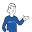

[<a href="/search?q=cliktrue&amp;sca_esv=c64f92f75d6f9f24&amp;gbv=1&amp;sei=a4E-Z76pFcTK1sQPgeru-Qc">aqui</a>,
 <a class="gyPpGe" data-ved="0ahUKEwj-iqGSmOyJAxVEpZUCHQG1O38Q67oDCAU" jsaction="i3viod" jsname="BKxS1e" role="link" tabindex="0">Ir para o conteúdo principal</a>,
 <a class="gyPpGe" data-sb="/url?sa=t&amp;source=web&amp;rct=j&amp;url=https://support.google.com/websearch/answer/181196%3Fhl%3Dpt-BR&amp;ved=0ahUKEwj-iqGSmOyJAxVEpZUCHQG1O38QwcMDCAY&amp;opi=89978449&amp;usg=AOvVaw2xBPSMLZirRL0hQqAkaKPW" href="https://support.google.com/websearch/answer/181196?hl=pt-BR" jsname="KI37ad">Ajuda sobre acessibilidade</a>,
 <a class="gyPpGe" data-async-trigger="duf3-78" jsaction="trigger.szjOR" jsname="JUypV" role="link" tabindex="0">Feedback de acessibilidade</a>,
 <a data-hveid="8" href="https://www.google.com/webhp?hl=pt-BR&amp;sa=X&amp;ved=0ahUKEwj-iqGSmOyJAxVEpZUCHQG1O38QPAgI" id="logo" title="Ir para a página inicial do Google"><svg height="30" viewbox="0 0 92 30" width="92" xmlns=
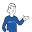
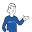
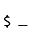

In [19]:
index = 3
query = "+".join(base['name_normalized'].iloc[index].split())
search_url = f"https://www.google.com/search?q={query}"

# Configuração de headers para simular um navegador
user_agents = [
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
"Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:90.0) Gecko/20100101 Firefox/90.0"
]

headers = {"User-Agent": random.choice(user_agents)}

# Fazer a requisição ao Google
response = requests.get(search_url, headers=headers)
#print(response, search_url, headers)

soup = BeautifulSoup(response.text, "html.parser")
#print(soup)

main_data=soup.find_all("a")



keyword = base["name_normalized_cortado"][index] #"musicart"
pattern = rf'href="(https://.*{keyword}.*\.com/)"'

# for i in main_data[:21]:
#     match = re.search(pattern, str(i))
#     if match:
#         print("URL encontrada:", match.group())
#     else:
#         print("URL não encontrada")

link_primeiro_site_encontrado = []

for keyword in base['name_normalized_cortado'][index]:
    print(keyword)
    #pattern = rf'href="(https://.*{keyword}.*\.com/)"'
    #pattern = rf'href="(https://.*{keyword}.*\.com(?:\.br)?/?.*?)"'
    #pattern = rf'href="(https://[^"]*{keyword}[^"]*\.com(?:\.br)?/?)"'
    #pattern = rf'href="(https://[^"]*{keyword}[^"]*\.(com|org)(?:\.br)?/?)"'
    #pattern = rf'href="(https?://[^"]*{keyword}[^"]*\.(com|org)(?:\.br)?/?)"'
    #pattern = rf'href="(https?://[^"]*{keyword}[^"]*\.(com|org)(?:\.br)?[^"]*)'
    pattern = rf'href="(https?://[^"]*{keyword}\.(com|org)(?:\.br)?[^"]*)'
    for i in main_data[:21]:
        match = re.search(pattern, str(i))
        if match:
            print("URL encontrada:", match.group())
            if match.group() not in link_primeiro_site_encontrado:
                link_primeiro_site_encontrado.append(match.group(1))
    if link_primeiro_site_encontrado == []:
        for element in [8,15]:
            if len(main_data[element].get('href')) < 100:
                link_primeiro_site_encontrado.append(main_data[element].get('href'))
    if link_primeiro_site_encontrado == []:
        for i in main_data[8:21]:
            pattern_1 = rf'href="(https?://[^"]*{keyword}[^"]*[^/]*?)"'
            match = re.search(pattern_1, str(i))
            if match:
                    link_primeiro_site_encontrado.append(match.group(1))
print(link_primeiro_site_encontrado)


print(main_data[14:17])
print(keyword)
main_data